# Timezones

Change or remove time zones from time series data


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)

In [4]:
## testing our saved data
df = pd.read_csv("../Data/Baltimore/baltimore_crime_counts_2023.csv", parse_dates=['CrimeDateTime'], index_col=0)

## Dealing with Timezones
Notice above that our datetime index has very large number of 0's.
Why are we seeing this? Is this related to the datetime index frequency?
let's check!

In [5]:
## check our df.index
df.index

DatetimeIndex(['2011-01-01 00:00:00+00:00', '2011-01-02 00:00:00+00:00',
               '2011-01-03 00:00:00+00:00', '2011-01-04 00:00:00+00:00',
               '2011-01-05 00:00:00+00:00', '2011-01-06 00:00:00+00:00',
               '2011-01-07 00:00:00+00:00', '2011-01-08 00:00:00+00:00',
               '2011-01-09 00:00:00+00:00', '2011-01-10 00:00:00+00:00',
               ...
               '2023-03-16 00:00:00+00:00', '2023-03-17 00:00:00+00:00',
               '2023-03-18 00:00:00+00:00', '2023-03-19 00:00:00+00:00',
               '2023-03-20 00:00:00+00:00', '2023-03-21 00:00:00+00:00',
               '2023-03-22 00:00:00+00:00', '2023-03-23 00:00:00+00:00',
               '2023-03-24 00:00:00+00:00', '2023-03-25 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=4467, freq=None)

## UTC vs. Time Zones
Notice the dtype is 'datetime64[ns, UTC]'
Previously, our datetime indices had a dtype of 'datetime64[ns], so what has changed?
We now have a timezone! the +00:00 is how Panda's Timestamps represent time zone.
UTC is the default time standard, which is not technically a time zone, but it is the standard global time without a timezone.
All timezones are then a specific # of hours +/- off from UTC. For example, Pacific Standard TIME (PST) is UTC - 7 hours.
To learn more about UTC visit https://www.utctime.net/
Let's see if resampling our data as daily frequency will remove the 00:00:00 for Hours/Mins/Seconds.

In [6]:
df = df.resample('D').asfreq()
df.head(3)

,RAPE,LARCENY,LARCENY FROM AUTO,AGG. ASSAULT,BURGLARY,COMMON ASSAULT,AUTO THEFT,ROBBERY,ROBBERY - COMMERCIAL,ARSON,ROBBERY - CARJACKING,HOMICIDE,SHOOTING
CrimeDateTime,,,,,,,,,,,,,
2011-01-01 00:00:00+00:00,5,39,27,28,21,41,15,5,2,1.0,NaN,NaN,NaN
2011-01-02 00:00:00+00:00,2,20,20,6,19,14,5,10,1,0.0,NaN,NaN,NaN
2011-01-03 00:00:00+00:00,1,19,16,13,21,15,7,9,1,0.0,NaN,NaN,NaN


As we can see, time zone-aware Timestamps will always display this level of detail, even when we have set our frequency to lower than a time (in this case days).

Let's pull out the first value of the index and display it.

In [7]:
ts0 = df.index[0]
ts0

Timestamp('2011-01-01 00:00:00+0000', tz='UTC', freq='D')

As we can see, it now displays that the tz='UTC'.
A single timestamp has a .astimezone() method that will display the datetime to the requested time zone.

In [8]:
# checking the documentation for astimezone
ts0.astimezone?

- As we can see in the docstring above, astimezone accepts several different types of arguments for the time zone, one option is a pytz.timezone
- For a list of all of the named time zones that are available in the pytz module, we can import it and then check the pytz.all_timezones variable.

In [9]:
import pytz
all_tzs = pytz.all_timezones
len(all_tzs)

596

Wow! That is a lot of time zones!

Let's limit our results to only those times zones in the US:

In [10]:
## getting just US timezones
[tz for tz in all_tzs if tz.startswith('US')]

['US/Alaska',
 'US/Aleutian',
 'US/Arizona',
 'US/Central',
 'US/East-Indiana',
 'US/Eastern',
 'US/Hawaii',
 'US/Indiana-Starke',
 'US/Michigan',
 'US/Mountain',
 'US/Pacific',
 'US/Samoa']

In [11]:
## let's try converting to US Eastern
ts0.astimezone('US/Eastern')

Timestamp('2010-12-31 19:00:00-0500', tz='US/Eastern', freq='D')

We can see that now that we have changed to another time zone, we will now start to see an actual hour appear in our time and the +00:00 now reflects the hours difference between UTC and the selected time zone.
Let's compare these to our original ts and see if we identify any unexpected problems.

In [12]:
## Viewing original 
ts0

Timestamp('2011-01-01 00:00:00+0000', tz='UTC', freq='D')

In [13]:
## let's try converting to US Pacific
ts0.astimezone('US/Pacific')

Timestamp('2010-12-31 16:00:00-0800', tz='US/Pacific', freq='D')

Do you notice anything weird?
Converting the time zone has caused us to change the date! Our original Timestamp was from "2011-01-01" but the converted US/Pacific time zone now has a date of "2010-12-31"!
For many operations, time zone-aware time series can actually cause issues.
If it's not required, it is best to remove the time zone altogether, especially when we are dealing with days or a lower frequency such as weeks.
## To convert to time zone-naive timestamps
With a single timestamp, we cannot remove time zone altogether.
But when we have a datetime index, we can convert the entire index to a time zone-naïve index by using df.tz_convert(None)

In [14]:
## remove time zone from the dt index
df = df.tz_convert(None)
df.head(3)

,RAPE,LARCENY,LARCENY FROM AUTO,AGG. ASSAULT,BURGLARY,COMMON ASSAULT,AUTO THEFT,ROBBERY,ROBBERY - COMMERCIAL,ARSON,ROBBERY - CARJACKING,HOMICIDE,SHOOTING
CrimeDateTime,,,,,,,,,,,,,
2011-01-01,5,39,27,28,21,41,15,5,2,1.0,NaN,NaN,NaN
2011-01-02,2,20,20,6,19,14,5,10,1,0.0,NaN,NaN,NaN
2011-01-03,1,19,16,13,21,15,7,9,1,0.0,NaN,NaN,NaN


Now that we have removed the time zone, we have much cleaner values in our CrimeDateTime Index.

# Seasonality


Let's select a few crimes from our DataFrame to visualize.


In [15]:
crimes = ['LARCENY','LARCENY FROM AUTO', 'AUTO THEFT','SHOOTING','ROBBERY - CARJACKING']
crimes_ts = df[crimes].copy()
crimes_ts.head()

,LARCENY,LARCENY FROM AUTO,AUTO THEFT,SHOOTING,ROBBERY - CARJACKING
CrimeDateTime,,,,,
2011-01-01,39,27,15,NaN,NaN
2011-01-02,20,20,5,NaN,NaN
2011-01-03,19,16,7,NaN,NaN
2011-01-04,29,12,10,NaN,NaN
2011-01-05,30,14,10,NaN,NaN


In [16]:
crimes_ts.isna().sum()


LARCENY                   0
LARCENY FROM AUTO         0
AUTO THEFT                0
SHOOTING                386
ROBBERY - CARJACKING      7
dtype: int64

In [17]:
## fill null values with 0
crimes_ts = crimes_ts.fillna(0)
crimes_ts

,LARCENY,LARCENY FROM AUTO,AUTO THEFT,SHOOTING,ROBBERY - CARJACKING
CrimeDateTime,,,,,
2011-01-01,39,27,15,0.0,0.0
2011-01-02,20,20,5,0.0,0.0
2011-01-03,19,16,7,0.0,0.0
2011-01-04,29,12,10,0.0,0.0
2011-01-05,30,14,10,0.0,0.0
...,...,...,...,...,...
2023-03-21,30,10,22,4.0,3.0
2023-03-22,28,10,17,1.0,2.0
2023-03-23,31,9,10,11.0,0.0


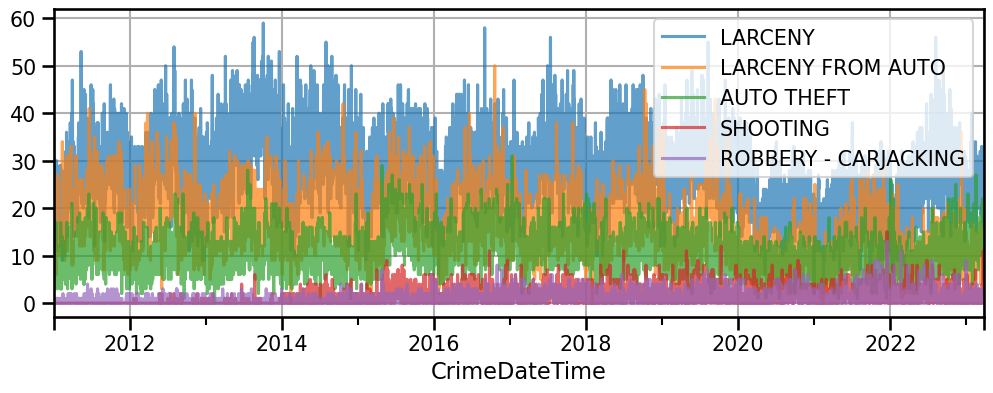

In [18]:
crimes_ts.plot(grid=True,alpha=0.7);


## Identifying Seasonality
We want to identify any patterns that may occur within our time series.
Whenever we have a periodic change in the values of a time series that repeats, we consider it to have "seasonality".
Just like the temperature and weather will change with the seasons, many time series also exhibit natural fluctuations, but the time period of a season can vary wildly.
Let's zoom in on ~5 years of data and take a closer look

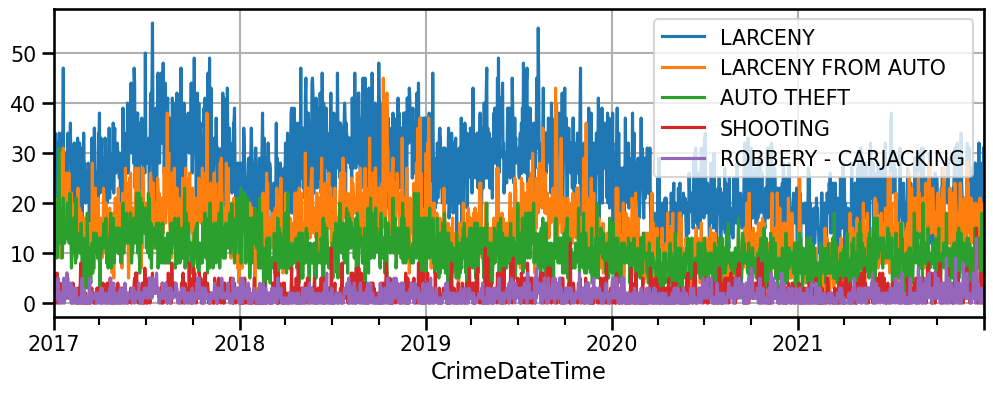

In [19]:
plot_df = crimes_ts.loc['2017':'2021']
plot_df.plot(grid=True);

Let's separate each crime into its own plot using subplots = True



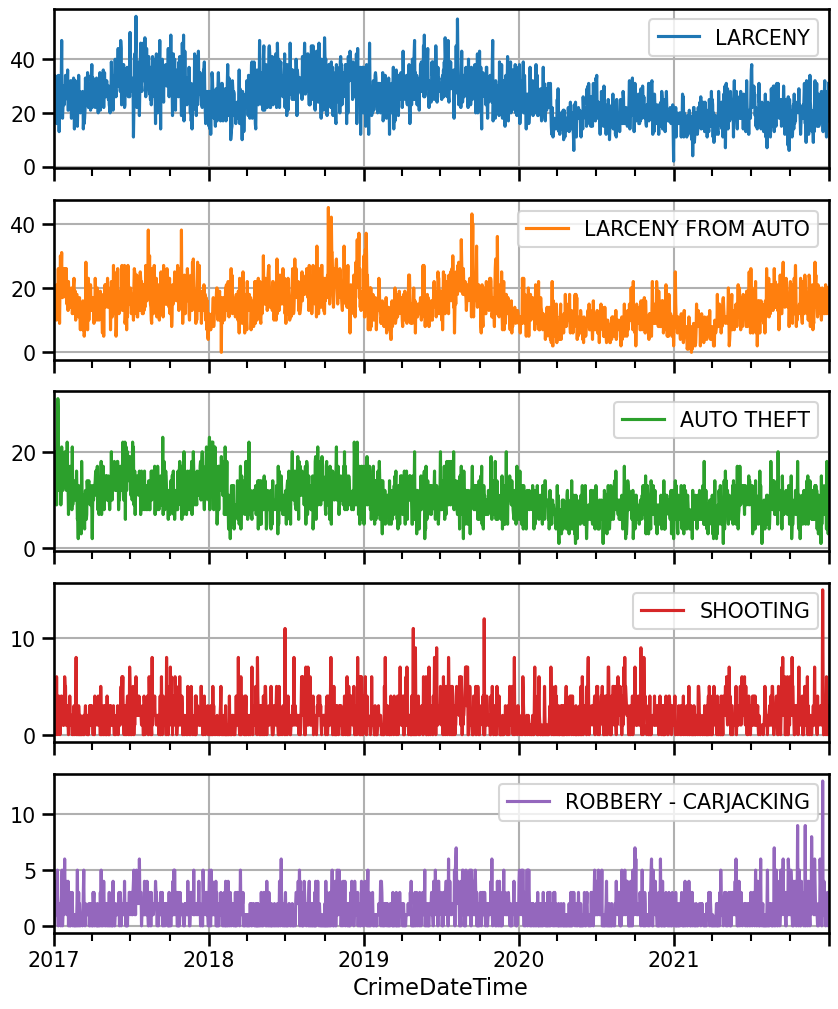

In [20]:
plot_df.plot(subplots=True,figsize=(10,12),grid=True);


Right now our time series has too small of a frequency for us to identify these patterns.
Let's try resampling to weekly frequency and visualize again.
## Resampling to a Larger Frequency
Since our crime data was in daily frequency, let's try resampling it as weekly data.
We will want to sum the values from each day to get the weekly value.

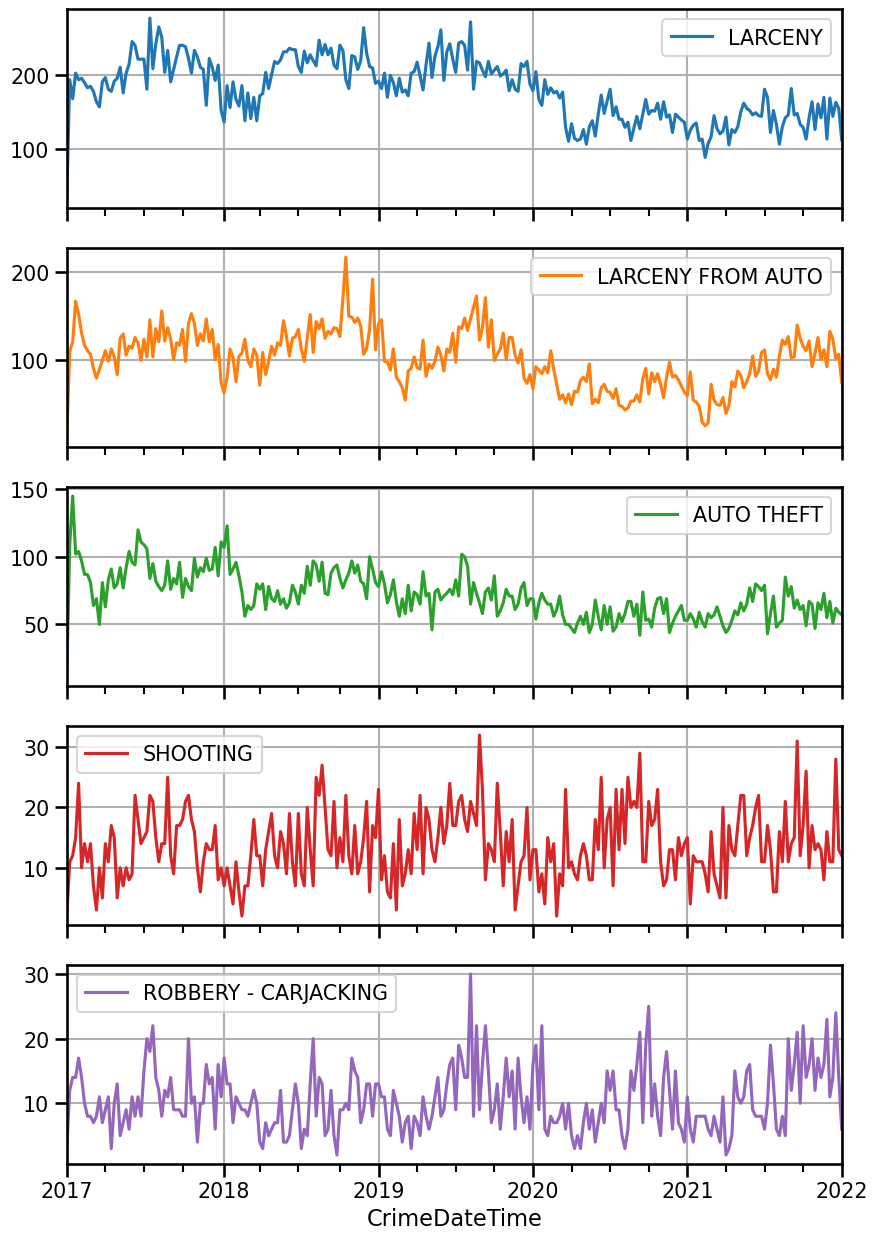

In [21]:
plot_df_W = crimes_ts.loc['2017':'2021'].resample('W').sum()
plot_df_W.plot(grid=True,subplots=True,figsize=(10,15));

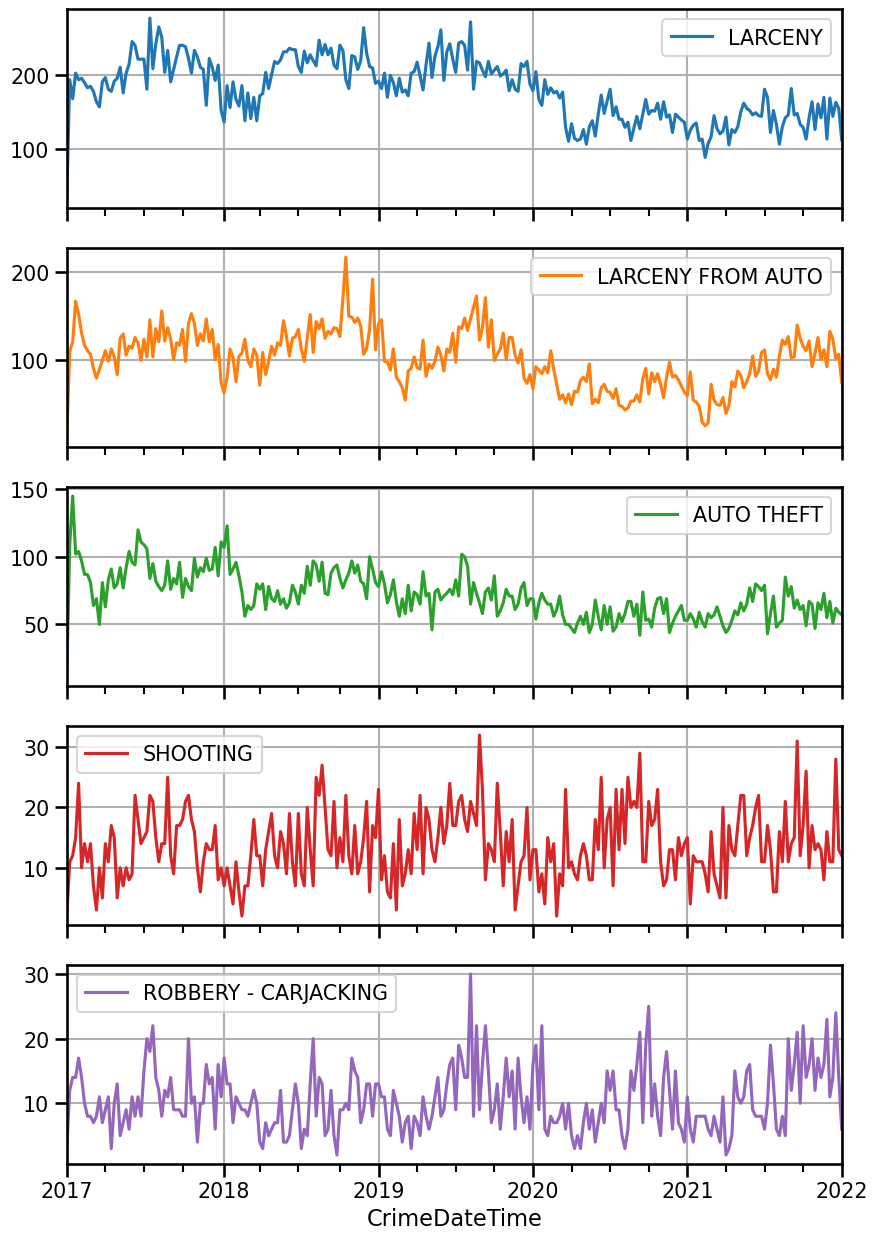

In [22]:
plot_df_W = crimes_ts.loc['2017':'2021'].resample('W').sum()
plot_df_W.plot(grid=True,subplots=True,figsize=(10,15));

It is still a bit difficult to identify patterns when there are large fluctuations between time steps.

The effect of the random changes between each time step can make it more difficult to identify seasonality.

## Using Rolling Mean to Smooth Time Series
We can leverage using the rolling mean with a window of 4 weeks to further smooth the data.

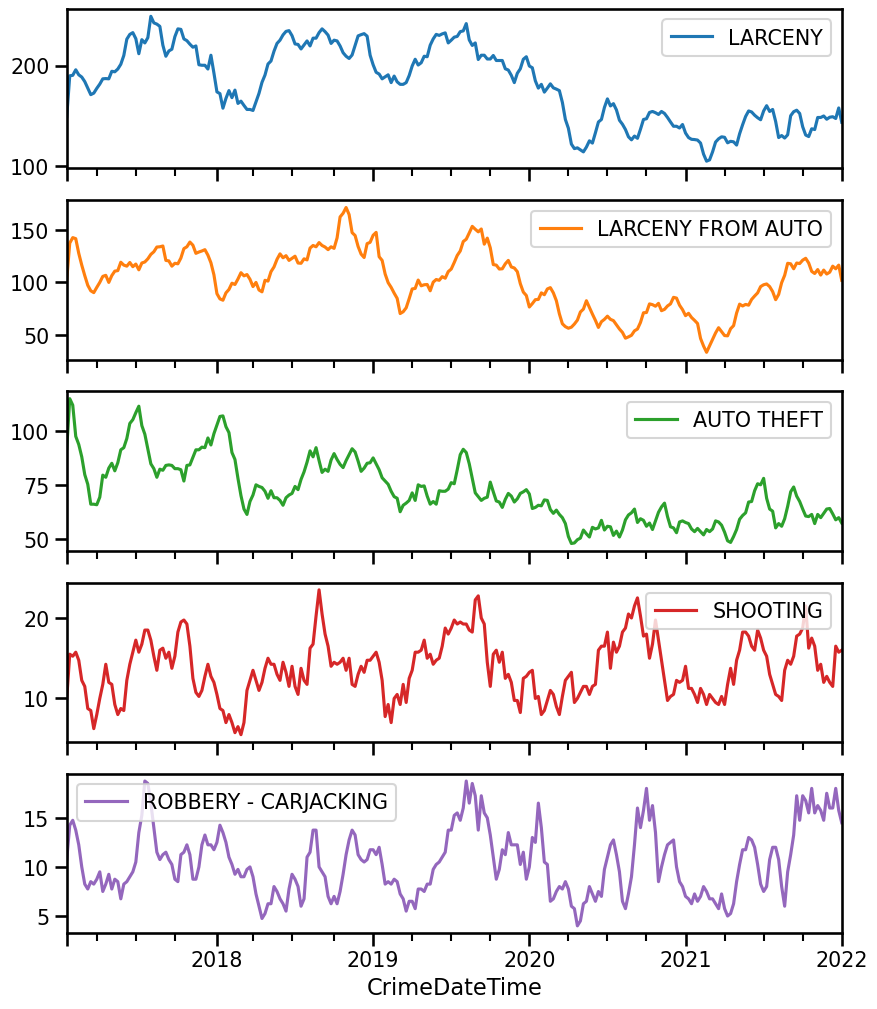

In [23]:
plot_df_W.rolling(4).mean().dropna().plot(subplots=True,figsize=(10,12));


Now that we have taken a 4-week moving average for our weekly crime data, we are starting to observe some cyclical patterns in our crimes.
It looks like shootings, auto theft, and maybe larceny have seasonality to them.
How can we isolate the seasonal fluctuation in our crime data to better understand the effect of a season? And can we do so without having to smooth our data?
## Seasonal Decomposition
Statsmodels has a function for dividing time series data into 3 components, called seasonal_decompose

The function will decompose the time series into 3 components
the trend component (slow, gradual, non-cyclical changes over time)
the seasonal component (cyclical changes)
and the residuals (the remaining fluctuations after removing the trend and seasonal component).
Let's apply this function to our LARCENY FROM AUTO data.

In [24]:
# import the statsmodels time series analysis api module
import statsmodels.tsa.api as tsa
tsa

<module 'statsmodels.tsa.api' from '/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/api.py'>

<AxesSubplot: title={'center': 'LARCENY FROM AUTO'}, xlabel='CrimeDateTime'>

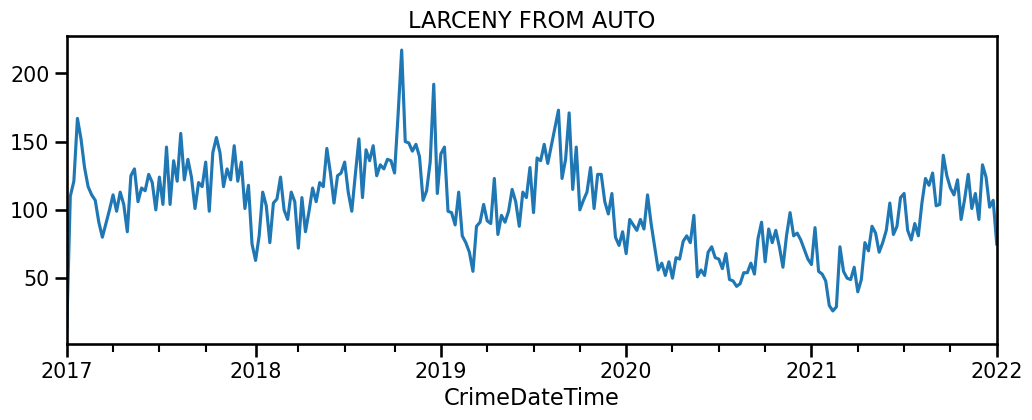

In [25]:
crime_type = "LARCENY FROM AUTO"
ts = plot_df_W[crime_type]
ts.plot(title=crime_type)

In [26]:
decomp = tsa.seasonal_decompose(ts)
decomp

The DecomposeResult object itself doesn't show us very much, but it contains a lot of information.
## Visualizing Decomposed Results
We can use the .plot() method to visualize the results!

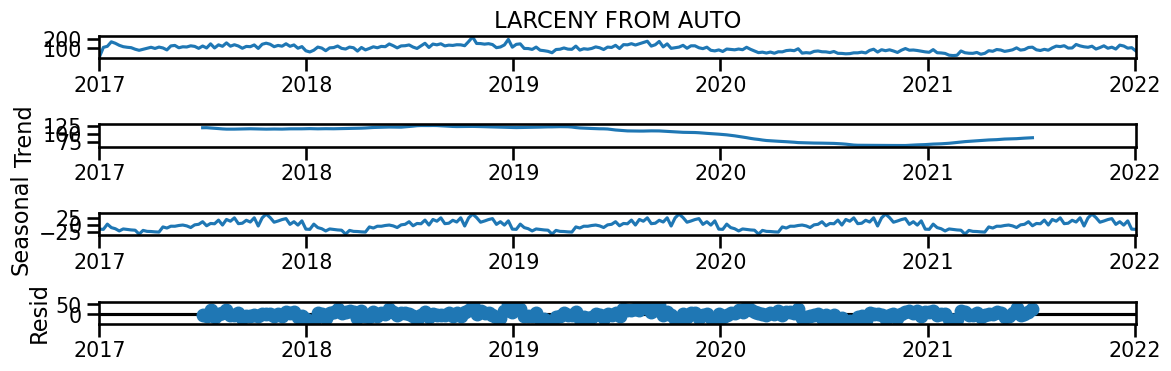

In [27]:
fig = decomp.plot()


Unfortunately, there is no way to tell the seasonal decomposition to use a different figsize.
However, we can update a figure's size after it is created using the fig.set_size_inches() method.
We will also want to use expand the subplots to fill in the larger figsize, which we can do using the fig.tight_layout() method.

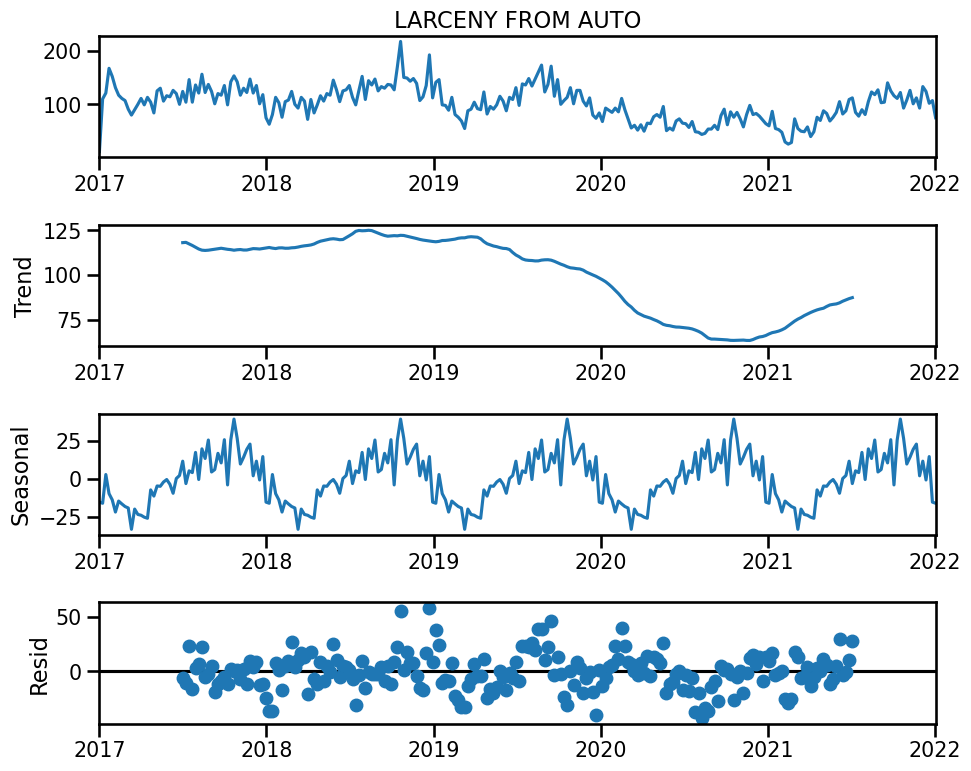

In [29]:
fig = decomp.plot()
fig.set_size_inches(10,8)
fig.tight_layout()

Here we can see the:
the original raw ts on top
followed by the slower non-cyclical trend
followed by the cyclical seasonal component
and finally the residuals after removing the trend and seasonal components.
## Inspecting the Individual Components
We can access pandas Series for each of the components using dot-indexing.
## Decomposed - Trend

In [30]:
decomp.trend

CrimeDateTime
2017-01-01   NaN
2017-01-08   NaN
2017-01-15   NaN
2017-01-22   NaN
2017-01-29   NaN
              ..
2021-12-05   NaN
2021-12-12   NaN
2021-12-19   NaN
2021-12-26   NaN
2022-01-02   NaN
Freq: W-SUN, Name: trend, Length: 262, dtype: float64

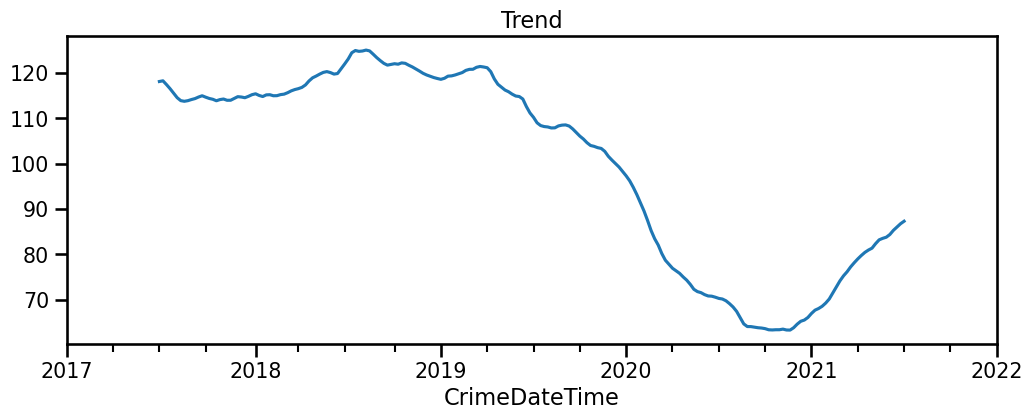

In [31]:
decomp.trend.plot(title='Trend');


## Decomposed - Seasonal


In [32]:
decomp.seasonal.head()


CrimeDateTime
2017-01-01   -15.365348
2017-01-08   -16.098521
2017-01-15     2.778883
2017-01-22    -9.761982
2017-01-29   -13.838905
Freq: W-SUN, Name: seasonal, dtype: float64

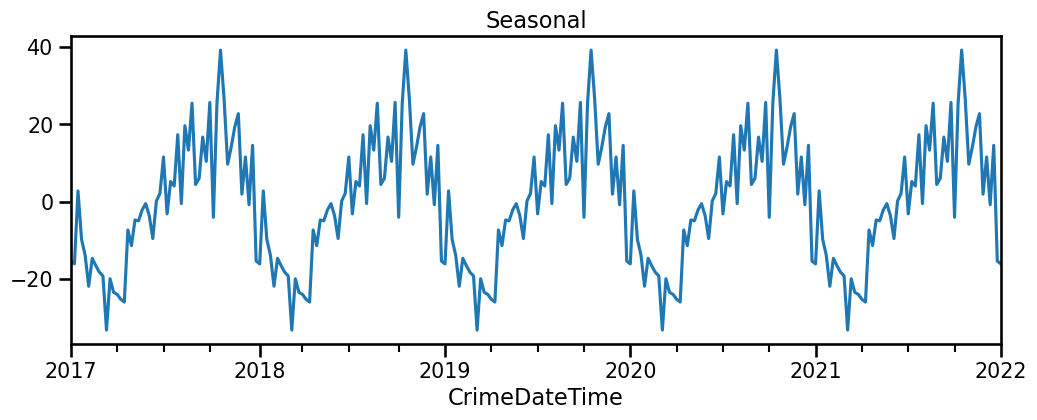

In [33]:
decomp.seasonal.plot(title='Seasonal');


## Decomposed Residuals


In [35]:
decomp.resid.head()


CrimeDateTime
2017-01-01   NaN
2017-01-08   NaN
2017-01-15   NaN
2017-01-22   NaN
2017-01-29   NaN
Freq: W-SUN, Name: resid, dtype: float64

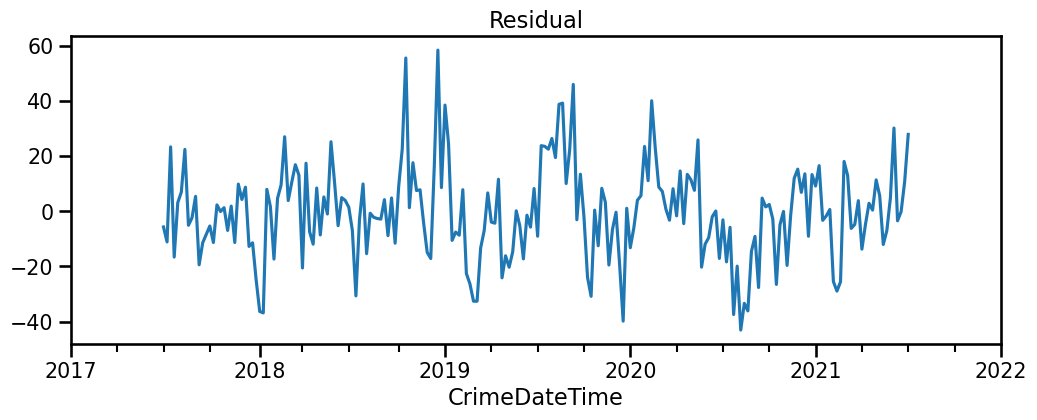

In [36]:
decomp.resid.plot(title='Residual');


## Decomposition's Separate Components
The decomposition separated the original raw time series into 3 components.
The default method for seasonal_decompose is to create components that can be added together to remake the original time series.
These 3 components' Series can simply be added together to reproduce the original time series.

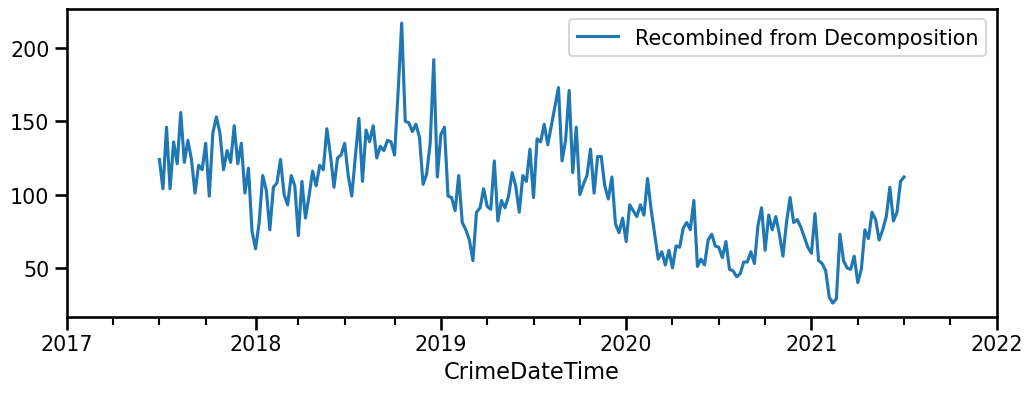

In [37]:
# Adding decomposition components together
ts_model = decomp.trend + decomp.seasonal + decomp.resid
# Visualize the result
ax = ts_model.plot(label='Recombined from Decomposition')
ax.legend()

If we graph the original time series behind our calculated, we can confirm if this matches the original raw data.

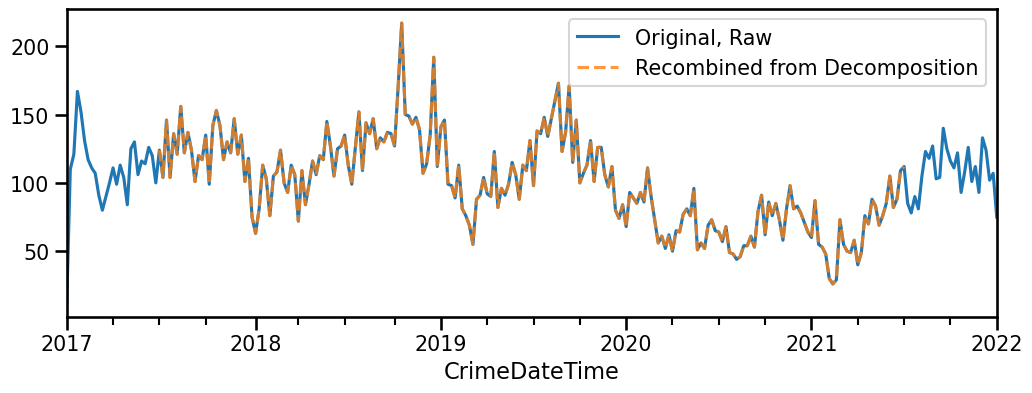

In [38]:
ax = ts.plot(label='Original, Raw')
ts_model.plot(label='Recombined from Decomposition',ax=ax, ls='--', alpha=0.8)
ax.legend();

We can see that the decomposition could not reproduce the very end and beginning of the raw time series.
However, the remainder of the time series lines up exactly and matches our original, raw data.
## Assessing Seasonal Contributions
Now that we can decompose a time series to extract the seasonal component, we can start answering questions about how much the time series varies across a season.

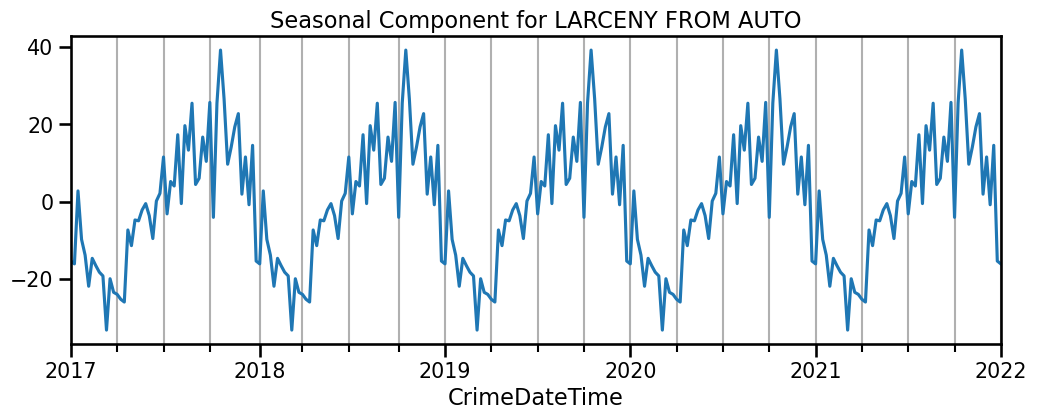

In [39]:
seasonal = decomp.seasonal
ax = seasonal.plot(title=f'Seasonal Component for {crime_type}');
ax.grid(which='both', axis='x')

The default x-axis ticks are too far apart for us to easily estimate the months of the peaks and valleys. -- If we leverage our matplotlib tick formatters and locators to add a minor tick for every month, it will make it much easier to digest.

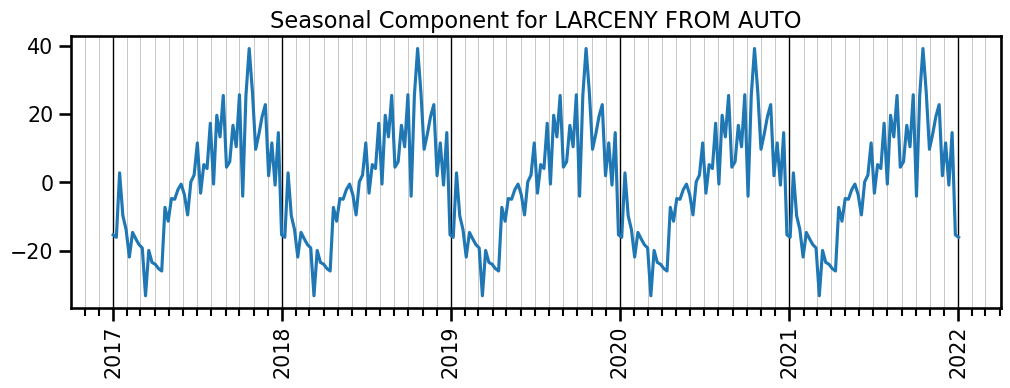

In [40]:
import matplotlib.dates as mdates
minor_loc = mdates.MonthLocator()
minor_fmt = mdates.DateFormatter("%d")
fig, ax = plt.subplots()
ax.plot(seasonal)
ax.set(title=f'Seasonal Component for {crime_type}');
ax.xaxis.set_minor_locator(minor_loc)
ax.grid(which='major', axis='x',lw=1, color='k')
ax.grid(which='minor',axis='x',lw=0.5)
fig.autofmt_xdate(rotation=90, ha='center')


By examining our visualization, we can see that there is a recurring pattern with the lowest # of crimes occurring in the month of march (approximately -30 crimes/week).
We then see a gradual increase until the seasonal component peaks in October (approximately +40), and finally a gradual decrease until march of the following year.
But let's get a more definitive answer than a simple visual inspection of our figure.

## Determining Seasonal Fluctuation - Magnitude
If we wanted to further quantify the magnitude of the seasonal change in the time series, we could measure the distance between the min and max values of the seasonal component.

In [41]:
seasonal.max()


39.20917159763314

In [42]:
seasonal.min()


-33.223520710059184

In [43]:
magnitude = seasonal.max() - seasonal.min()
magnitude

72.43269230769232

The is a seasonal fluctuation of ~ 72 crimes per week for Larceny from Auto.
## Determining the Duration of a Season
Let's identify the dates with the min and max (using idxmin/idxmax) and calculate the length of this time period.


In [44]:
seasonal.idxmax()

Timestamp('2017-10-22 00:00:00', freq='W-SUN')

In [45]:
seasonal.idxmin()


Timestamp('2017-03-12 00:00:00', freq='W-SUN')

## Annotating Periods
Since we are discussing a period of time, we will use an axvspan to annotate this instead of an axvline.
Matplotlib Documentation for ax.axvspan
We will be recreating our figure several times, so we will convert it into a very simple function.
We do not plan to reuse this function in new contexts in the future, so we can make it a very simple function.
It will take the seasonal variable as its only input.
It will return the fig and ax for the visualization.

# def plot_seasonal(seasonal):

In [47]:
import matplotlib.dates as mdates
def plot_seasonal(seasonal):
    minor_loc = mdates.MonthLocator()
    minor_fmt = mdates.DateFormatter("%d")
    fig, ax = plt.subplots()
    ax.plot(seasonal)
    ax.set(title=f'Seasonal Component for {crime_type}');
    ax.xaxis.set_minor_locator(minor_loc)
    ax.grid(which='major', axis='x',lw=1, color='k')
    ax.grid(which='minor',axis='x',lw=0.5)
    fig.autofmt_xdate(rotation=90, ha='center')
    
    return fig, ax

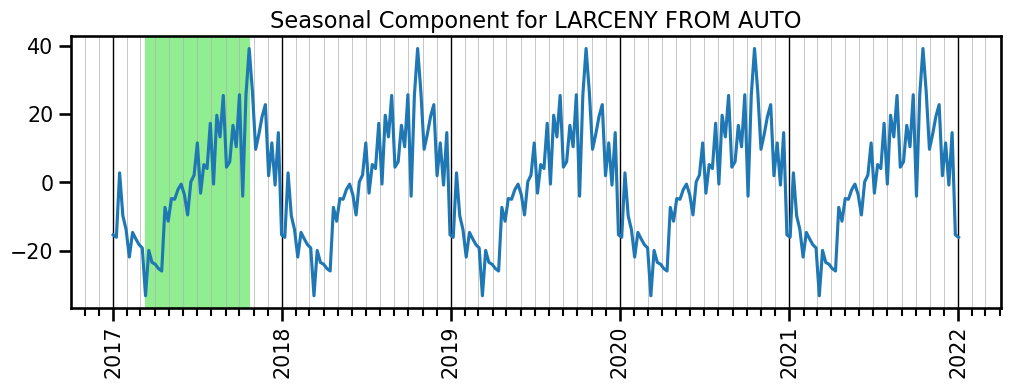

In [48]:
fig, ax = plot_seasonal(seasonal)
ax.axvspan(seasonal.idxmin(),seasonal.idxmax(), color='lightgreen');


We can see above that we have covered the duration from the first minimum to the first peak of our season.

In [49]:
delta = seasonal.idxmax() - seasonal.idxmin()
delta

Timedelta('224 days 00:00:00')

We can see that the difference between the min and max is a timedelta of 224 days.
To find the time for a full cycle (period) we need to calculate the time between one max and the next max.
## Using scipy's find_peaks Function.


We need to identify the maximum point of each season (the peaks). Then we can calculate the time between peaks as our seasonal period.
To do so, we can leverage a function from scipy's signal submodule.
Specifically, we will be using scipy.signal.find_peaks
It needs the time series as its first argument, and we will also specify the height of our expected peaks.
We know the maximum value of our seasonal component, which is our peak height!

In [50]:
from scipy.signal import find_peaks
peaks, props = find_peaks(seasonal, height=seasonal.max())


It returns 2 variables:
peaks: the integer index of the identified peaks
props: a dictionary with additional information calculated during the process of finding the peaks
In this case, we will get the actual heights of each peak.

In [51]:
peaks

array([ 42,  94, 146, 198, 250])

In [52]:
props

{'peak_heights': array([39.2091716, 39.2091716, 39.2091716, 39.2091716, 39.2091716])}

To get the dates from our datetime index that correspond to the integer index for the peaks, we can simply slice from our seasonal.index using the peaks' integer positions.

In [53]:
peak_dates = seasonal.index[peaks]
peak_dates

DatetimeIndex(['2017-10-22', '2018-10-21', '2019-10-20', '2020-10-18',
               '2021-10-17'],
              dtype='datetime64[ns]', name='CrimeDateTime', freq=None)

Now let's recreate our graph and then let's annotate the identified peaks.
Since we have both the date and peak value for each peak, we can add these values as an additional scatter plot on top of our original figure.

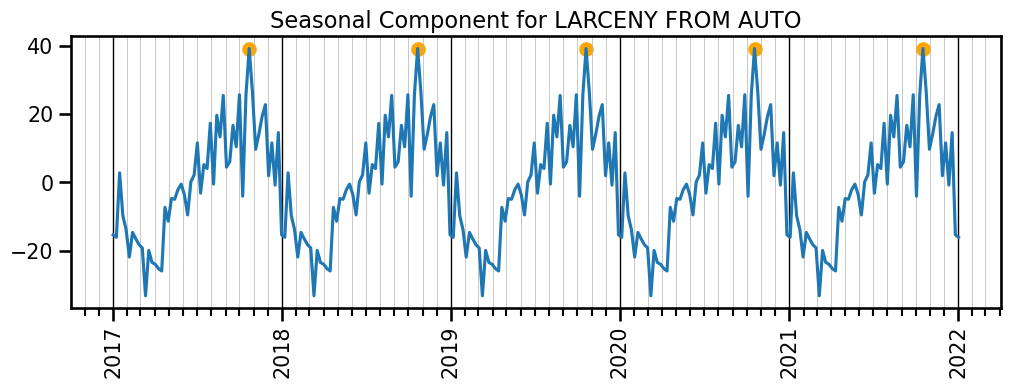

In [54]:
fig,ax = plot_seasonal(seasonal)
ax.scatter(peak_dates, props['peak_heights'], color='orange');

Ok, it looks like we have properly identified all of the peaks!
Now, let's calculate the length of a period using our peaks.
We can calculate the date of our second peak from our first to get the period.

In [55]:
peak_dates

DatetimeIndex(['2017-10-22', '2018-10-21', '2019-10-20', '2020-10-18',
               '2021-10-17'],
              dtype='datetime64[ns]', name='CrimeDateTime', freq=None)

In [56]:
period = peak_dates[1] - peak_dates[0]
period

Timedelta('364 days 00:00:00')

It looks like our crime's season is approximately a full year long (364 days).
Let's confirm this is the same for all dates using a loop:

In [57]:
periods = []
for i in range(len(peak_dates)-1):
    delta = peak_dates[i+1] - peak_dates[i]
    periods.append(delta)
periods

[Timedelta('364 days 00:00:00'),
 Timedelta('364 days 00:00:00'),
 Timedelta('364 days 00:00:00'),
 Timedelta('364 days 00:00:00')]

## Final Annotation
Now that we are confident that our period is 364 days let's annotate our season as an axvspan, and then the start date of the season as an axvline with a label.

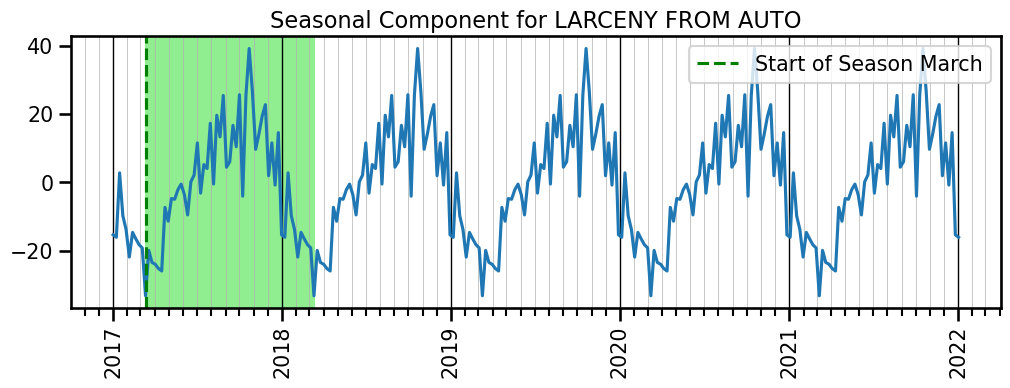

In [58]:
fig, ax = plot_seasonal(seasonal)
season_start = seasonal.idxmin()
ax.axvspan( season_start, season_start +period, color='lightgreen')
ax.axvline(season_start, color='green', ls='--',
           label=f"Start of Season {season_start.strftime('%B')}")
ax.legend();


In [59]:
seasonal.max() - seasonal.min()

72.43269230769232

And there we go! It aligns perfectly with the visualization!
We can see that there is seasonality in the # of larceny from auto crimes with a period of 364 days, with an overall seasonal fluctuation of ~72 crimes per week.